In [1]:
# This a toy-example demonstrates the creation of a Bell state and then applying
# a classical loop to keep mixing the state of the qubit until
# the prepared qubit is in the |0> state.
# The program uses a toy layer to define the quantum operations.
import qstack

program = None

In [2]:
%%qstack
@instruction-set: toy

allocate q1:
  mix q1
  allocate q2:
    entangle q1 q2
  measure
measure


[Kernel(targets=(QubitId(value='q1'),), instructions=(QuantumInstruction(name='mix', targets=[QubitId(value='q1')], parameters={}), Kernel(targets=(QubitId(value='q2'),), instructions=(QuantumInstruction(name='entangle', targets=[QubitId(value='q1'), QubitId(value='q2')], parameters={}),), callback=None)), callback=None)]

In [3]:
# Set up a local quantum machine to execute the program.
# Each machine in qstack is created to target a specific stack or instruction set.
# This ensures that the machine can correctly interpret and execute the program's instructions.
from qstack.machine import local_machine_for, create_callbacks

machine = local_machine_for(program.instruction_set)


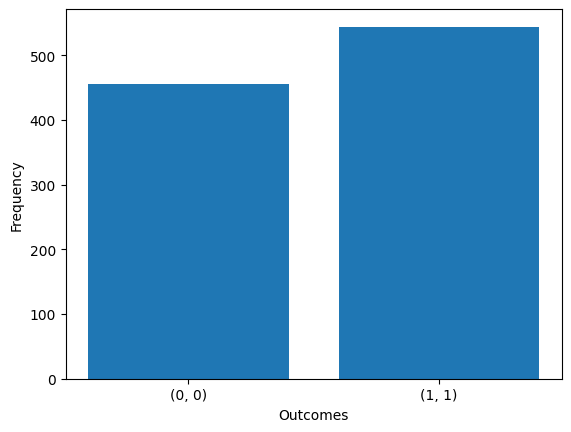

In [4]:
# Evaluate the program, it should give an even distribution betweek 
# (,0,0) and (1,1) when measuring the two qubits.

machine.eval(program).plot_histogram()


In [5]:
%%qstack
# Now incorporate a classical callback called repeat_until_zero...
# This callback will keep mixing the state of a qubit until the last outcome is "0".
@instruction-set: toy

allocate q1:
  mix q1
  allocate q2:
    entangle q1 q2
  measure
  ?? repeat_until_zero
measure


[Kernel(targets=(QubitId(value='q1'),), instructions=(QuantumInstruction(name='mix', targets=[QubitId(value='q1')], parameters={}), Kernel(targets=(QubitId(value='q2'),), instructions=(QuantumInstruction(name='entangle', targets=[QubitId(value='q1'), QubitId(value='q2')], parameters={}),), callback=ClassicInstruction(name='repeat_until_zero', parameters={}))), callback=None)]

In [6]:
## The actual classical implementation of the callback:
from qstack.instruction_sets.toy import Mix

# Define a classical callback for state preparation.
def repeat_until_zero(context):
    m = context.consume() 

    if m == 1:
        return qstack.Kernel(targets=["q"], instructions=[Mix("q")], callback=qstack.ClassicInstruction("repeat_until_zero", parameters={}))
    else:
        context.collect(m)
        return None



In [7]:
# We need a new machine for this program that can
# invoke the classical callback

callbacks = create_callbacks(repeat_until_zero)
machine = local_machine_for(program.instruction_set, callbacks)


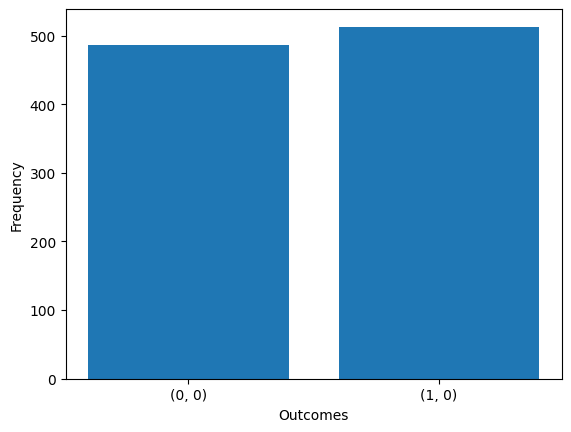

In [8]:
# The new histogram returns a distribution of
# (0,0) and (1,0) as the 

machine.eval(program).plot_histogram()


In [9]:
# Let's  turn on the logs
# and see the actual evaluation of the program.
# You'll notice that the number of calls to mix depends on the outcome as expected.
import logging

logger = logging.getLogger("qstack")

handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

In [10]:
machine.single_shot(program)

2025-05-17 22:14:56,642 - DEBUG - restart: 2
2025-05-17 22:14:56,648 - DEBUG - eval: mix [1]
2025-05-17 22:14:56,651 - DEBUG - eval: entangle [0, 1]
2025-05-17 22:14:56,652 - DEBUG - outcome: 1
2025-05-17 22:14:56,654 - DEBUG - eval: mix [0]
2025-05-17 22:14:56,655 - DEBUG - outcome: 1
2025-05-17 22:14:56,657 - DEBUG - eval: mix [0]
2025-05-17 22:14:56,658 - DEBUG - outcome: 1
2025-05-17 22:14:56,661 - DEBUG - eval: mix [0]
2025-05-17 22:14:56,668 - DEBUG - outcome: 1
2025-05-17 22:14:56,670 - DEBUG - eval: mix [0]
2025-05-17 22:14:56,673 - DEBUG - outcome: 0
2025-05-17 22:14:56,675 - DEBUG - outcome: 1


(1, 0)

In [15]:
machine.single_shot(program)

2025-05-17 12:04:31,070 - DEBUG - restart: 2
2025-05-17 12:04:31,073 - DEBUG - eval: mix [1]
2025-05-17 12:04:31,078 - DEBUG - eval: entangle [0, 1]
2025-05-17 12:04:31,080 - DEBUG - outcome: 1
2025-05-17 12:04:31,081 - DEBUG - eval: mix [0]
2025-05-17 12:04:31,082 - DEBUG - outcome: 0
2025-05-17 12:04:31,083 - DEBUG - outcome: 1


(1, 0)

In [27]:
machine.single_shot(program)

2025-05-17 12:04:39,944 - DEBUG - restart: 2
2025-05-17 12:04:39,947 - DEBUG - eval: mix [1]
2025-05-17 12:04:39,950 - DEBUG - eval: entangle [0, 1]
2025-05-17 12:04:39,951 - DEBUG - outcome: 1
2025-05-17 12:04:39,953 - DEBUG - eval: mix [0]
2025-05-17 12:04:39,954 - DEBUG - outcome: 1
2025-05-17 12:04:39,956 - DEBUG - eval: mix [0]
2025-05-17 12:04:39,957 - DEBUG - outcome: 1
2025-05-17 12:04:39,959 - DEBUG - eval: mix [0]
2025-05-17 12:04:39,961 - DEBUG - outcome: 0
2025-05-17 12:04:39,962 - DEBUG - outcome: 1


(1, 0)

In [ ]:
# Compile the toy program to the minimal Clifford instruction set.
# This step translates the toy instructions (like 'mix' and 'entangle')
# into a form that can be executed by a Clifford-based backend.
# Note: The classical callback (repeat_until_zero) may generate new kernels at runtime.
# When compiling, the compiler does not directly transform these dynamically generated kernels.
# Instead, it wraps the classical callback into a function that, when invoked, first evaluates
# the kernel and then just-in-time (JIT) compiles it before execution.
from qstack.compilers.toy2cliffords import ToyCompiler

compiler = ToyCompiler()
compiled, compiled_callbacks = compiler.compile(program, callbacks)

# Print the compiled program to see the transformed representation.
print(compiled)


2025-05-17 22:15:41,735 - WARNING - Instruction skew has no handler.


@instruction-set: cliffords-min

allocate q1:
  h q1
  allocate q2:
    cx q1 q2
  measure
  ?? _toy2cliffords_:repeat_until_zero
measure


In [23]:
# Evaluate the compiled program using the minimal Clifford instruction set.
# The logs will show that the quantum instructions evaluated are not those returned by the original callback,
# but the ones corresponding to those after compilation.
# The logs will not show that the kernel is compiled JIT, but you can observe the effect by the instructions executed.
machine = local_machine_for(compiled.instruction_set, compiled_callbacks)

machine.single_shot(compiled)

2025-05-17 22:29:53,781 - DEBUG - Found gate z: [[1, 0], [0, -1]]
2025-05-17 22:29:53,787 - DEBUG - Found gate cx: [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]
2025-05-17 22:29:53,792 - DEBUG - Found gate h: [[0.7071, 0.7071], [0.7071, -0.7071]]
2025-05-17 22:29:53,796 - DEBUG - Found gate x: [[0, 1], [1, 0]]
2025-05-17 22:29:53,798 - DEBUG - Found gate y: [[0, (-0-1j)], [1j, 0]]
2025-05-17 22:29:53,800 - DEBUG - Found gate cz: [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]]
2025-05-17 22:29:53,803 - DEBUG - restart: 2
2025-05-17 22:29:53,804 - DEBUG - eval: h [1]
2025-05-17 22:29:53,808 - DEBUG - eval: cx [0, 1]
2025-05-17 22:29:53,810 - DEBUG - outcome: 1
2025-05-17 22:29:53,812 - DEBUG - eval: h [0]
2025-05-17 22:29:53,814 - DEBUG - outcome: 0
2025-05-17 22:29:53,816 - DEBUG - outcome: 1


(1, 0)